# 📋 Visão Geral do Projeto — Electric Vehicle Resale Analytics

Você precisa analisar como diferentes características de veículos elétricos 
influenciam o **valor de revenda** (`Resale_Value_USD`), com três entregas principais:

1. **Parte #1 — Análise Exploratória de Dados (EDA) e Comparação de Grupos**
2. **Parte #2 — Tendências de Mercado ao Longo do Tempo**
3. **Parte #3 — Modelo Preditivo para o Valor de Revenda**

# 🚀 Passo 1: Preparação do Ambiente

Nesta etapa:
- Instalamos as dependências a partir do `requirements.txt`;
- Importamos as bibliotecas necessárias;
- Definimos constantes de caminho, parâmetros globais e funções utilitárias.

In [1]:
# Instalação das bibliotecas necessárias a partir do requirements.txt
!pip install -qq -r "../requirements.txt"

# (Opcional) Gerar um "requirements-lock" com as versões exatas do ambiente
# !pip freeze > "../requirements-lock.txt"

In [2]:
# Importação das bibliotecas
import warnings
warnings.filterwarnings("ignore")

import os
from pathlib import Path
from datetime import datetime

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

import statsmodels.api as sm
from statsmodels.formula.api import ols

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

import joblib

# Configurações de visualização
plt.style.use("seaborn-v0_8-darkgrid")
sns.set_palette("husl")
plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["font.size"] = 12

RANDOM_STATE = 42

print("✅ Bibliotecas importadas com sucesso!")
print(f"Versão do Pandas: {pd.__version__}")
print(f"Versão do NumPy: {np.__version__}")
print(f"Versão do Matplotlib: {matplotlib.__version__}")
print(f"Versão do Seaborn: {sns.__version__}")
print(f"Versão do Statsmodels: {sm.__version__}")


✅ Bibliotecas importadas com sucesso!
Versão do Pandas: 2.3.3
Versão do NumPy: 2.2.6
Versão do Matplotlib: 3.10.7
Versão do Seaborn: 0.13.2
Versão do Statsmodels: 0.14.5


## Constantes do Projeto

Definimos aqui:
- Caminhos de entrada/saída;
- Parâmetros globais (seed, tamanho de teste);
- Etiqueta de tempo para versionar saídas se necessário.


In [3]:
# ================================
# CONSTANTES DE CAMINHO E PARÂMETROS
# ================================

# Caminho de entrada (ajuste o nome do arquivo se necessário)
DATA_INPUT_PATH = Path("../data/inputs/electric_vehicle_analytics(in).csv")
if not DATA_INPUT_PATH.exists():
    # fallback para estrutura mais simples
    DATA_INPUT_PATH = Path("../data/electric_vehicle_analytics(in).csv")

# Diretórios de saída
DATA_OUTPUT_PATH = Path("../data/outputs")
FIGURES_PATH = DATA_OUTPUT_PATH / "figures"
REPORTS_PATH = DATA_OUTPUT_PATH / "reports"
MODELS_PATH = DATA_OUTPUT_PATH / "models"

for p in [DATA_OUTPUT_PATH, FIGURES_PATH, REPORTS_PATH, MODELS_PATH]:
    p.mkdir(parents=True, exist_ok=True)

# Parâmetros base
SEED = RANDOM_STATE
TEST_SIZE = 0.2

# Etiqueta temporal (para versionar artefatos, se quiser)
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

target_col = "Resale_Value_USD"

print("✅ Constantes definidas:")
print(f"DATA_INPUT_PATH: {DATA_INPUT_PATH}")
print(f"DATA_OUTPUT_PATH: {DATA_OUTPUT_PATH}")
print(f"FIGURES_PATH: {FIGURES_PATH}")
print(f"REPORTS_PATH: {REPORTS_PATH}")
print(f"MODELS_PATH: {MODELS_PATH}")
print(f"SEED: {SEED}, TEST_SIZE: {TEST_SIZE}")


✅ Constantes definidas:
DATA_INPUT_PATH: ..\data\inputs\electric_vehicle_analytics(in).csv
DATA_OUTPUT_PATH: ..\data\outputs
FIGURES_PATH: ..\data\outputs\figures
REPORTS_PATH: ..\data\outputs\reports
MODELS_PATH: ..\data\outputs\models
SEED: 42, TEST_SIZE: 0.2


In [4]:
def load_data(path: Path) -> pd.DataFrame:
    """
    Carrega o dataset de veículos elétricos a partir de um arquivo CSV.

    Parameters
    ----------
    path : Path
        Caminho para o arquivo CSV.

    Returns
    -------
    pd.DataFrame
        DataFrame com os dados carregados e ajustes básicos de tipo.
    """
    if not path.exists():
        raise FileNotFoundError(f"Arquivo não encontrado: {path}")

    df = pd.read_csv(path)
    df = df.copy()

    # Ajustes básicos de tipo
    if "Year" in df.columns:
        df["Year"] = df["Year"].astype(int)
    if "Vehicle_ID" in df.columns:
        df["Vehicle_ID"] = df["Vehicle_ID"].astype(int)

    # Ordenar por ano (facilita análises temporais)
    if "Year" in df.columns:
        df = df.sort_values("Year").reset_index(drop=True)

    return df

In [5]:
def summarize_dataframe(df: pd.DataFrame, df_name: str = "df") -> None:
    """
    Exibe um resumo sucinto do DataFrame: dimensão, tipos, nulos e estatísticas básicas.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame a ser resumido.
    df_name : str, optional
        Nome lógico do DataFrame para identificação.
    """
    print(f"=== Resumo do DataFrame: {df_name} ===")
    print(f"Dimensão: {df.shape[0]} linhas x {df.shape[1]} colunas\n")

    print("Tipos de dados:")
    print(df.dtypes)
    print("\nValores nulos (top 10):")
    nulls = df.isna().sum().sort_values(ascending=False)
    print(nulls.head(10))

    print("\nEstatísticas descritivas (numéricas):")
    display(df.describe(include="number").T.round(2))

    print("\nEstatísticas descritivas (categóricas):")
    display(df.describe(include="object").T)


# 📊 Passo 2: Parte #1 — Análise Exploratória de Dados (EDA) e Comparação de Grupos

Agora vamos construir a EDA, seguindo etapas bem claras:

1. Carregamento e visão geral dos dados;
2. Análise de valores ausentes;
3. Estatísticas descritivas;
4. Distribuição de variáveis numéricas e categóricas;
5. Comparação de grupos (fabricante, região, tipo de veículo, tipo de uso) em relação ao valor de revenda;
6. Testes estatísticos (ANOVA) e correlações com a variável-alvo.

In [6]:
# ========================================
# PARTE 1: ANÁLISE EXPLORATÓRIA DE DADOS
# ========================================

# 1. CARREGAMENTO DOS DADOS
# ---------------------------
print("=" * 60)
print("1. CARREGAMENTO DOS DADOS")
print("=" * 60)

df = load_data(DATA_INPUT_PATH)
print(f"✅ Dataset carregado com sucesso a partir de: {DATA_INPUT_PATH}")
print(f"Dimensões: {df.shape[0]} linhas x {df.shape[1]} colunas\n")

1. CARREGAMENTO DOS DADOS
✅ Dataset carregado com sucesso a partir de: ..\data\inputs\electric_vehicle_analytics(in).csv
Dimensões: 3000 linhas x 25 colunas



In [7]:
# 2. VISÃO GERAL DO DATAFRAME
# ----------------------------
print("=" * 60)
print("2. VISÃO GERAL DO DATAFRAME")
print("=" * 60)
summarize_dataframe(df, "electric_vehicle_analytics")

2. VISÃO GERAL DO DATAFRAME
=== Resumo do DataFrame: electric_vehicle_analytics ===
Dimensão: 3000 linhas x 25 colunas

Tipos de dados:
Vehicle_ID                            int64
Make                                 object
Model                                object
Year                                  int64
Region                               object
Vehicle_Type                         object
Battery_Capacity_kWh                float64
Battery_Health_%                    float64
Range_km                              int64
Charging_Power_kW                   float64
Charging_Time_hr                    float64
Charge_Cycles                         int64
Energy_Consumption_kWh_per_100km    float64
Mileage_km                            int64
Avg_Speed_kmh                       float64
Max_Speed_kmh                         int64
Acceleration_0_100_kmh_sec          float64
Temperature_C                       float64
Usage_Type                           object
CO2_Saved_tons              

,count,mean,std,min,25%,50%,75%,max
Vehicle_ID,3000.0,1500.50,866.17,1.00,750.75,1500.50,2250.25,3000.00
Year,3000.0,2019.50,2.85,2015.00,2017.00,2020.00,2022.00,2024.00
Battery_Capacity_kWh,3000.0,74.81,25.73,30.00,53.00,74.85,96.90,120.00
Battery_Health_%,3000.0,85.03,8.59,70.00,77.78,85.25,92.30,100.00
Range_km,3000.0,374.41,137.18,121.00,260.00,371.00,476.25,713.00
Charging_Power_kW,3000.0,129.30,68.74,11.10,70.90,126.70,187.98,250.00
Charging_Time_hr,3000.0,1.20,1.42,0.14,0.46,0.72,1.29,12.14
Charge_Cycles,3000.0,1107.01,510.83,200.00,674.75,1116.00,1535.25,1997.00
Energy_Consumption_kWh_per_100km,3000.0,18.59,3.77,12.00,15.32,18.70,21.83,24.99
Mileage_km,3000.0,125209.69,70465.77,5046.00,65140.50,125965.00,184764.75,249987.00



Estatísticas descritivas (categóricas):


,count,unique,top,freq
Make,3000,10,Ford,323
Model,3000,23,Niro EV,163
Region,3000,4,Australia,794
Vehicle_Type,3000,4,Hatchback,773
Usage_Type,3000,3,Personal,1020


In [8]:
# 3. ANÁLISE DE VALORES AUSENTES
# -------------------------------
print("\n" + "=" * 60)
print("3. ANÁLISE DE VALORES AUSENTES")
print("=" * 60)

missing = (
    df.isna()
    .sum()
    .to_frame("missing_count")
    .assign(missing_pct=lambda x: x["missing_count"] / len(df))
    .sort_values("missing_pct", ascending=False)
)
display(missing.head(20))

missing.to_csv(REPORTS_PATH / f"missing_values_{timestamp}.csv", index=True)
print(f"📁 Relatório de nulos salvo em: {REPORTS_PATH / f'missing_values_{timestamp}.csv'}")


3. ANÁLISE DE VALORES AUSENTES


,missing_count,missing_pct
Vehicle_ID,0,0.0
Make,0,0.0
Model,0,0.0
Year,0,0.0
Region,0,0.0
Vehicle_Type,0,0.0
Battery_Capacity_kWh,0,0.0
Battery_Health_%,0,0.0
Range_km,0,0.0
Charging_Power_kW,0,0.0


📁 Relatório de nulos salvo em: ..\data\outputs\reports\missing_values_2025-12-02_13-42-13.csv



4. ANÁLISE DE VARIÁVEIS NUMÉRICAS
Variáveis numéricas (19):
['Year', 'Battery_Capacity_kWh', 'Battery_Health_%', 'Range_km', 'Charging_Power_kW', 'Charging_Time_hr', 'Charge_Cycles', 'Energy_Consumption_kWh_per_100km', 'Mileage_km', 'Avg_Speed_kmh', 'Max_Speed_kmh', 'Acceleration_0_100_kmh_sec', 'Temperature_C', 'CO2_Saved_tons', 'Maintenance_Cost_USD', 'Insurance_Cost_USD', 'Electricity_Cost_USD_per_kWh', 'Monthly_Charging_Cost_USD', 'Resale_Value_USD']


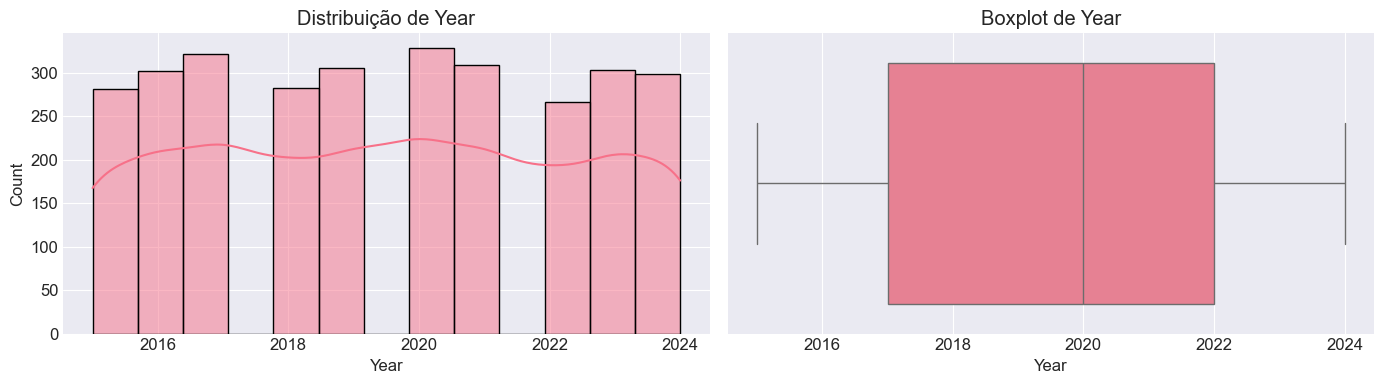

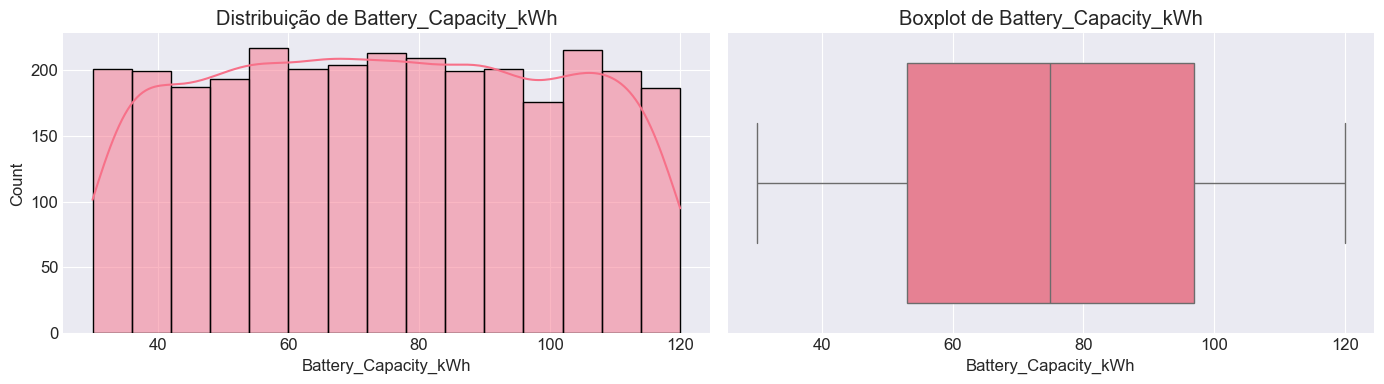

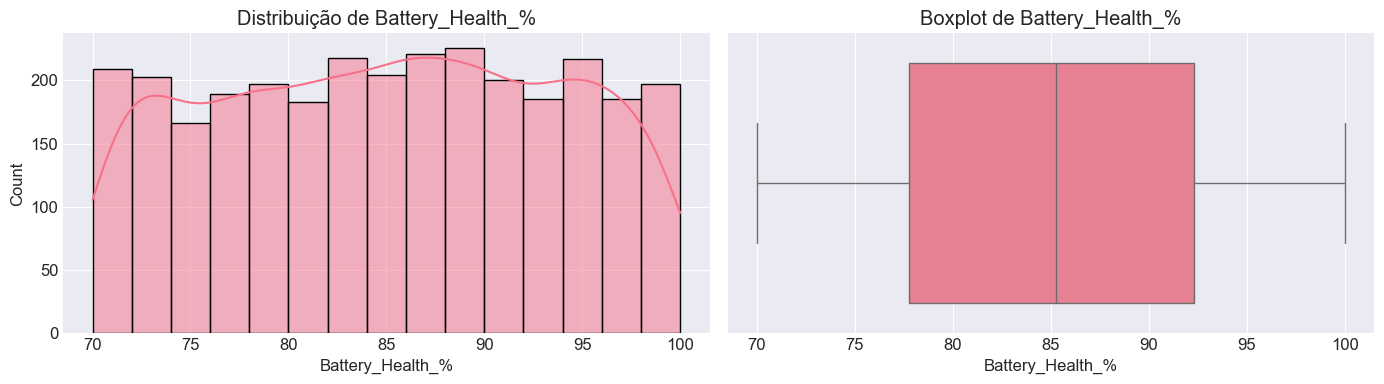

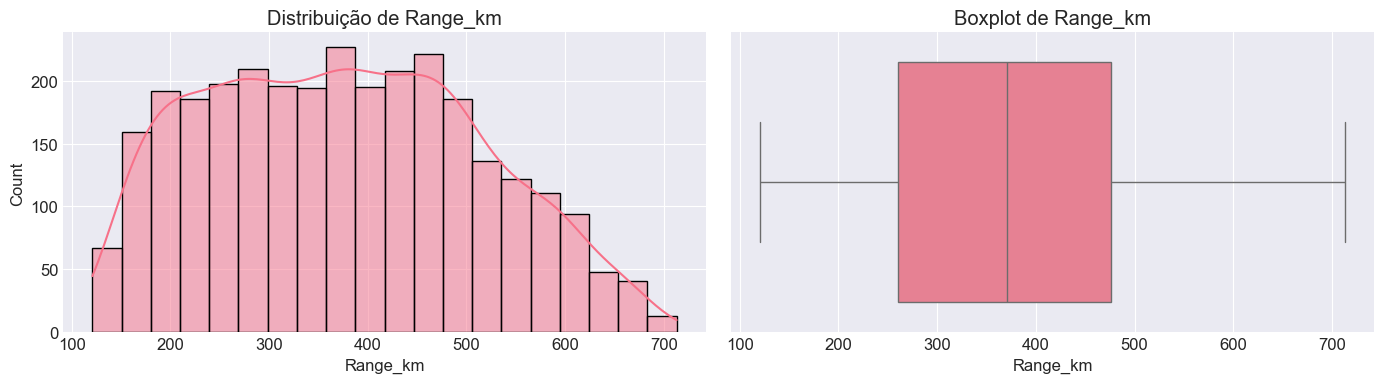

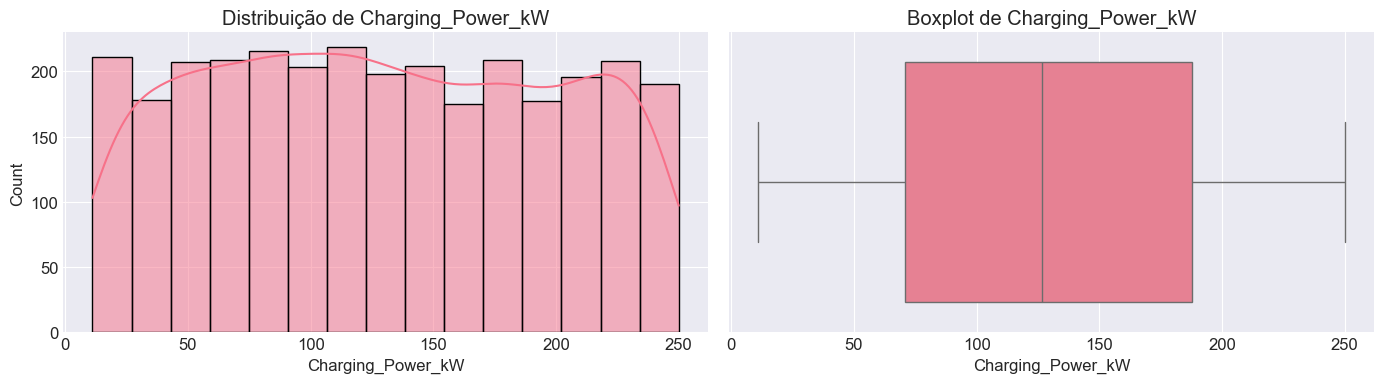

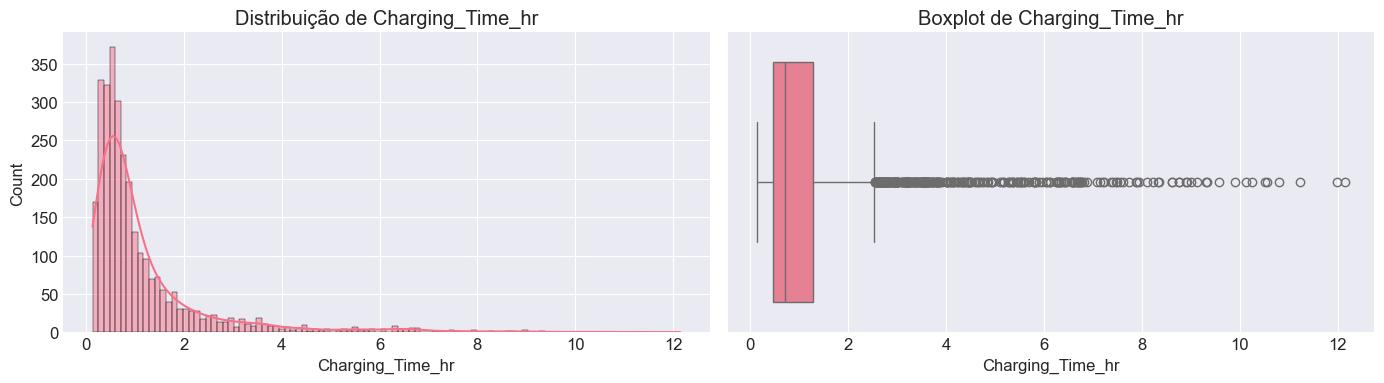

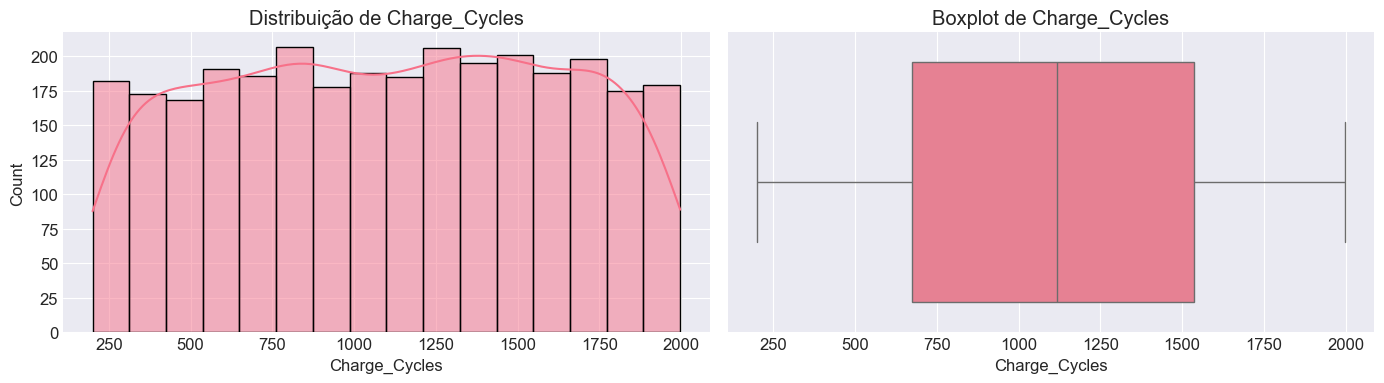

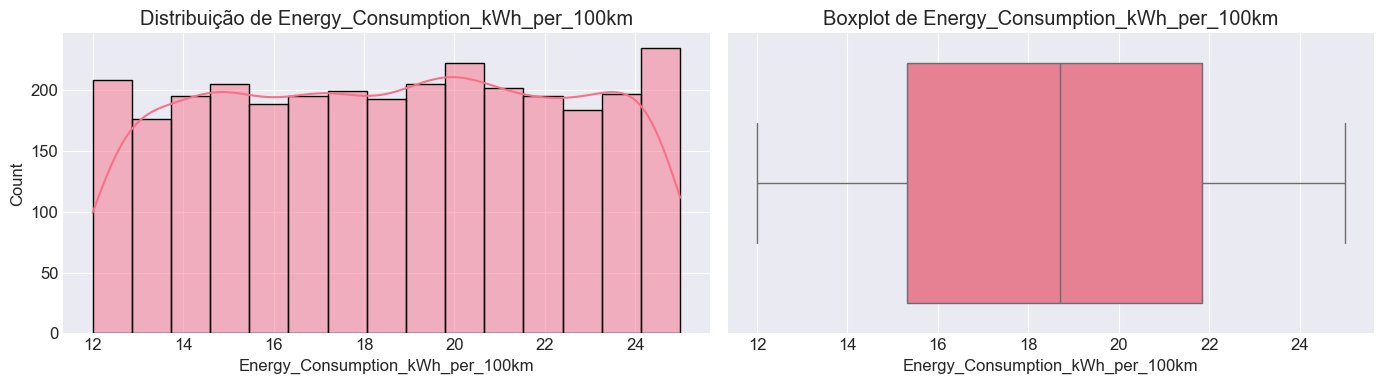

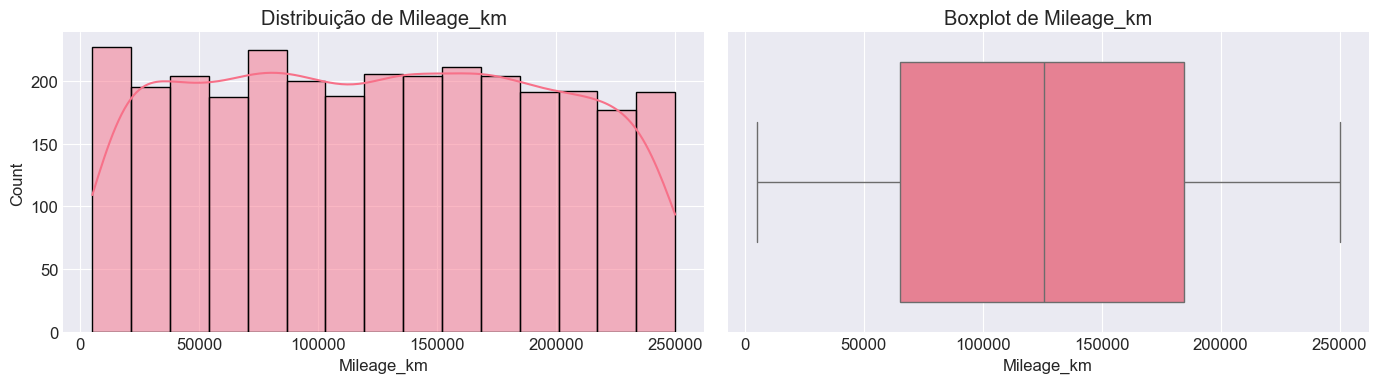

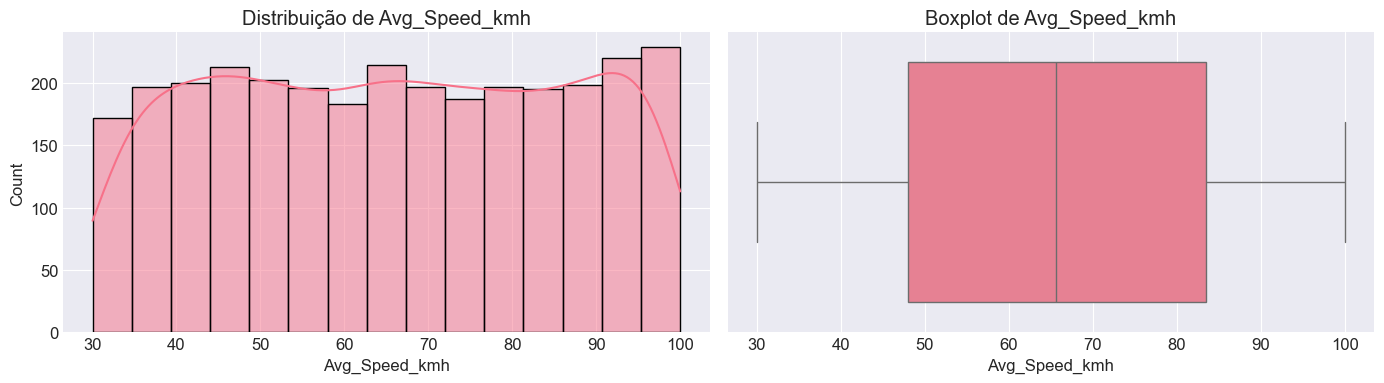

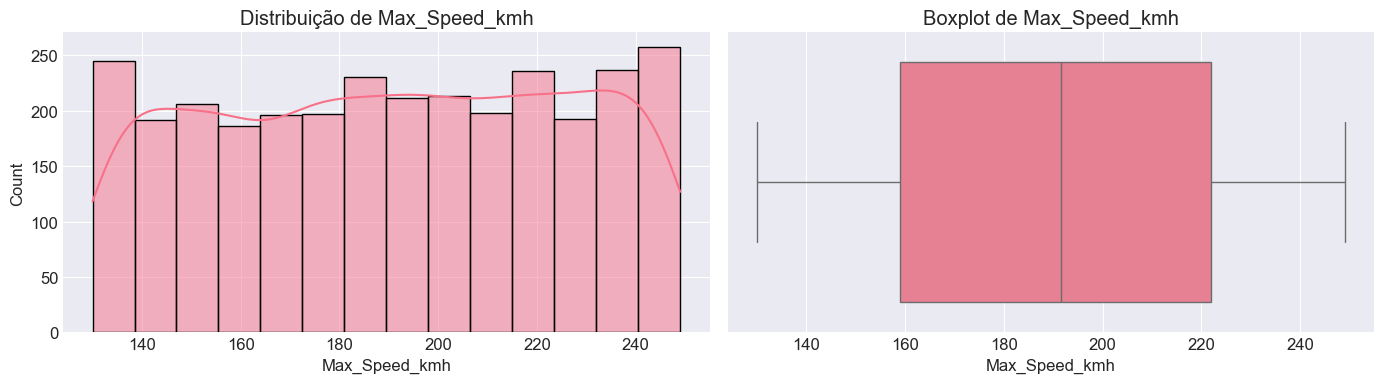

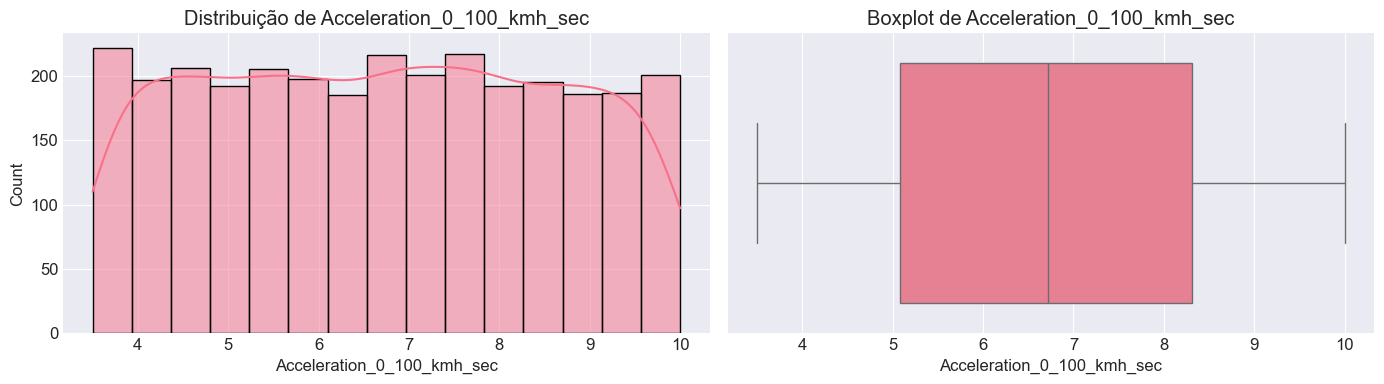

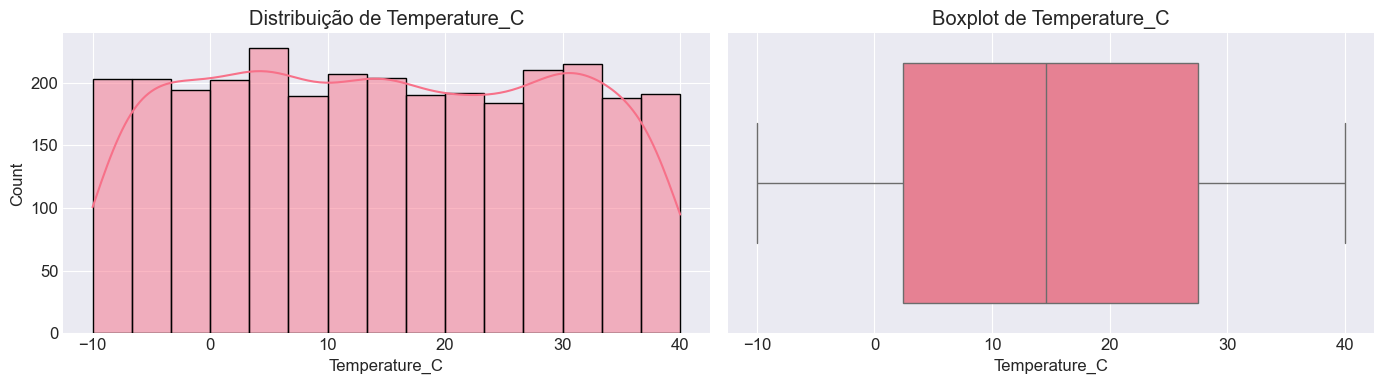

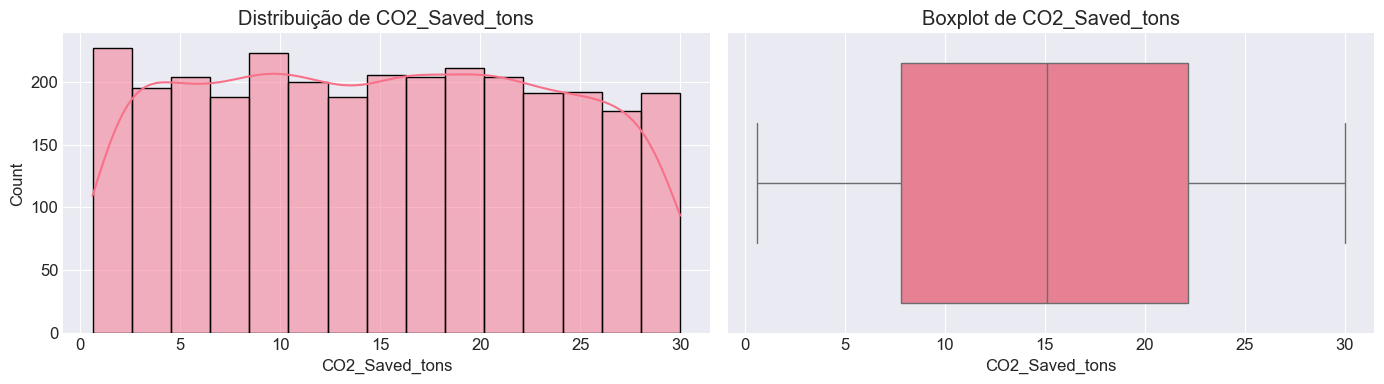

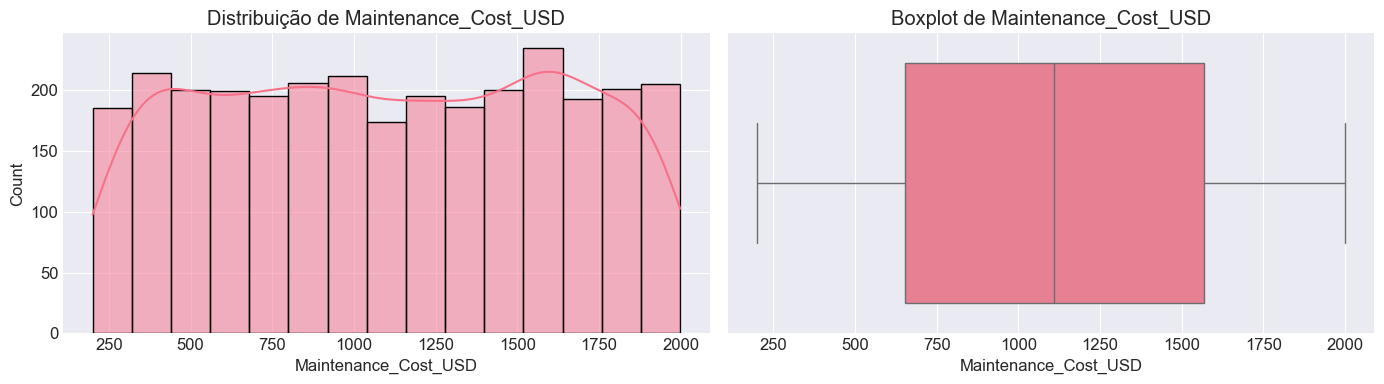

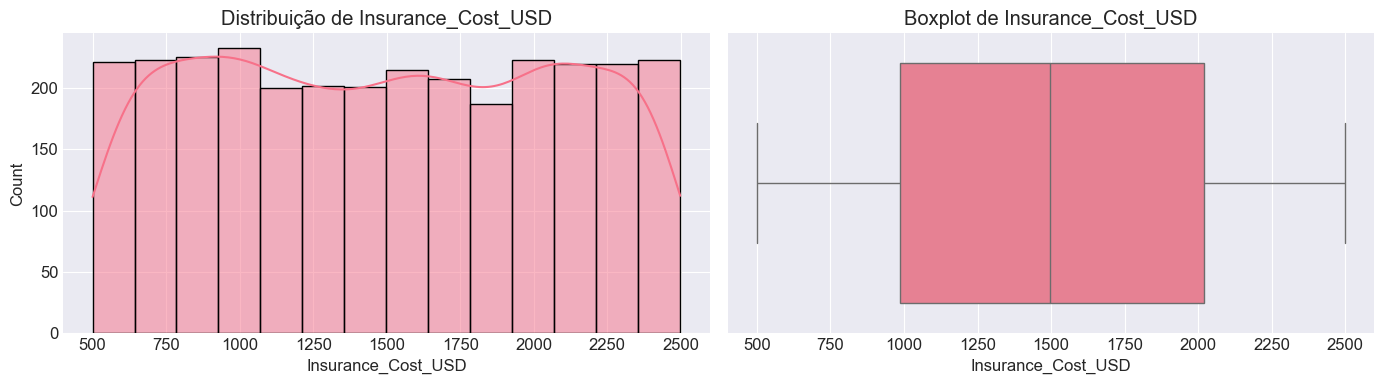

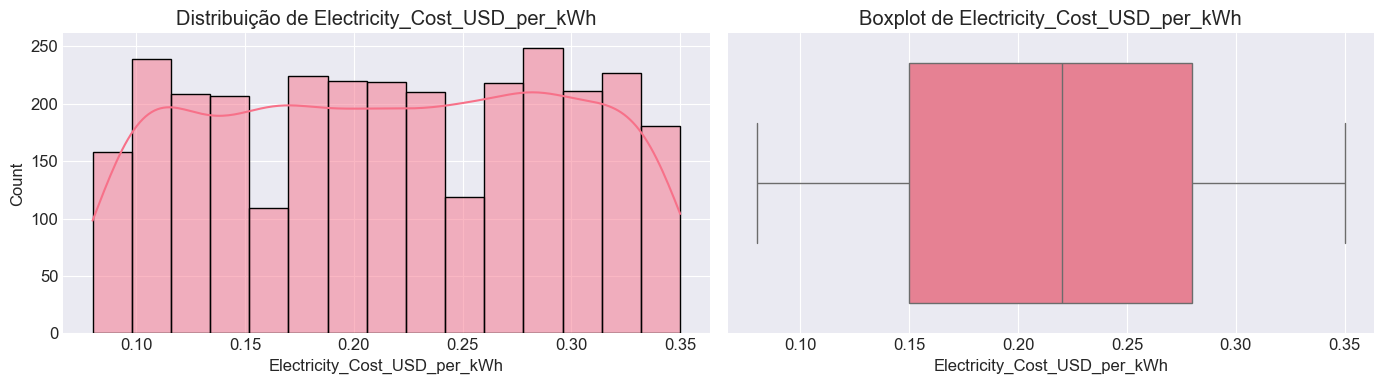

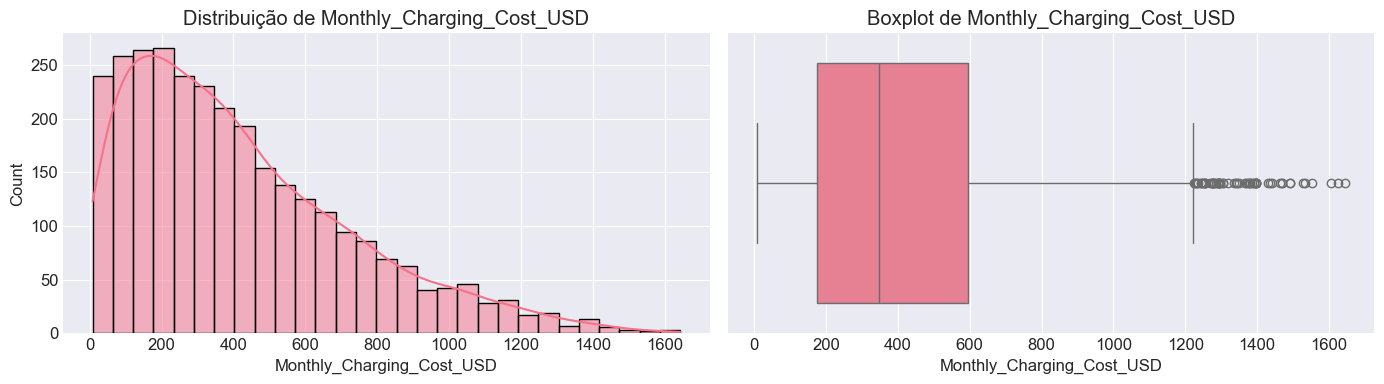

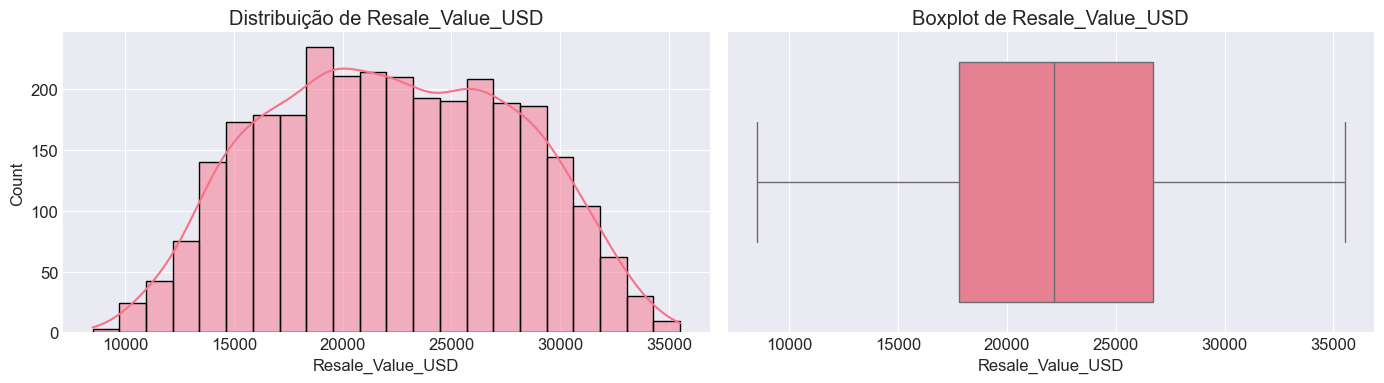

In [9]:
# 4. ANÁLISE DE VARIÁVEIS NUMÉRICAS
# ----------------------------------
print("\n" + "=" * 60)
print("4. ANÁLISE DE VARIÁVEIS NUMÉRICAS")
print("=" * 60)

numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols = [c for c in numeric_cols if c not in ["Vehicle_ID"]]  # remover ID

print(f"Variáveis numéricas ({len(numeric_cols)}):")
print(numeric_cols)

for col in numeric_cols:
    fig, axes = plt.subplots(1, 2, figsize=(14, 4))

    sns.histplot(df[col], kde=True, ax=axes[0])
    axes[0].set_title(f"Distribuição de {col}")

    sns.boxplot(x=df[col], ax=axes[1])
    axes[1].set_title(f"Boxplot de {col}")

    plt.tight_layout()
    plt.show()


5. ANÁLISE DE VARIÁVEIS CATEGÓRICAS
Variáveis categóricas (5):
['Make', 'Model', 'Region', 'Vehicle_Type', 'Usage_Type']


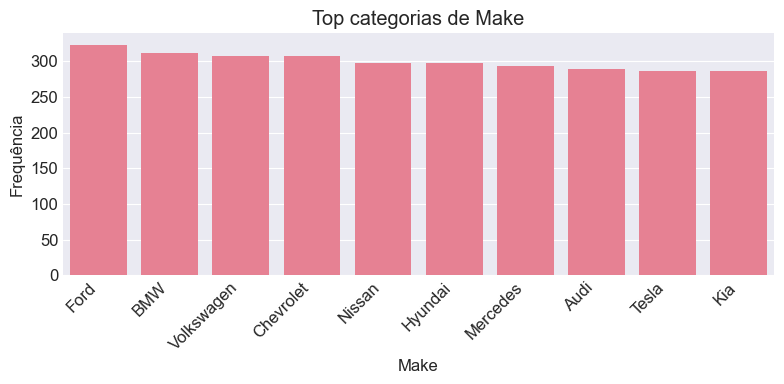

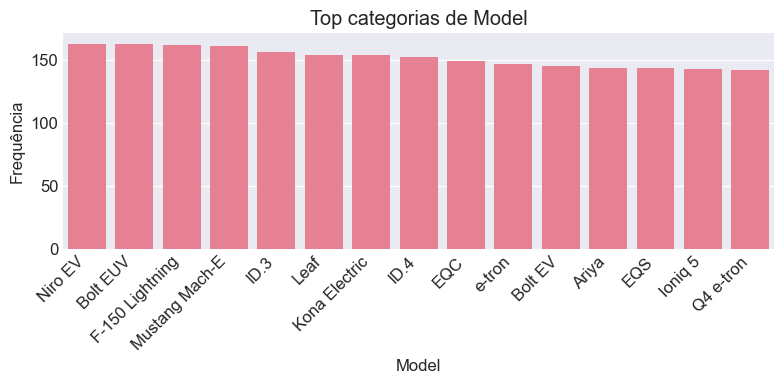

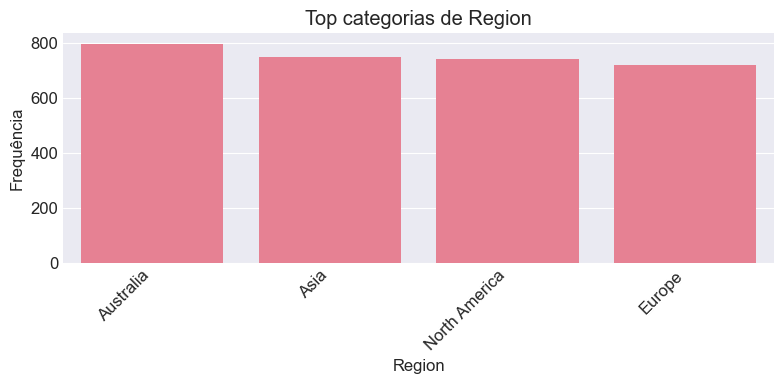

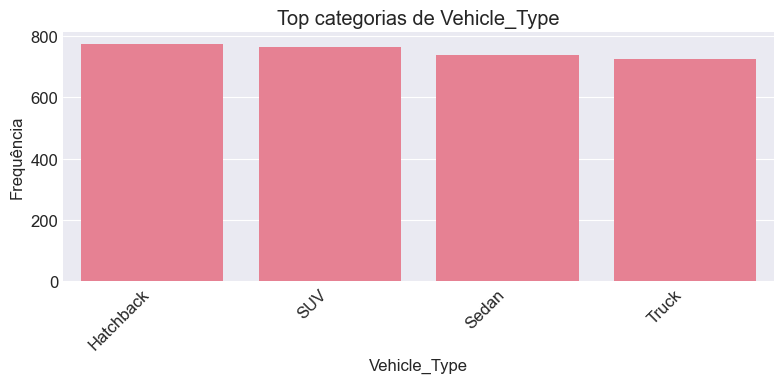

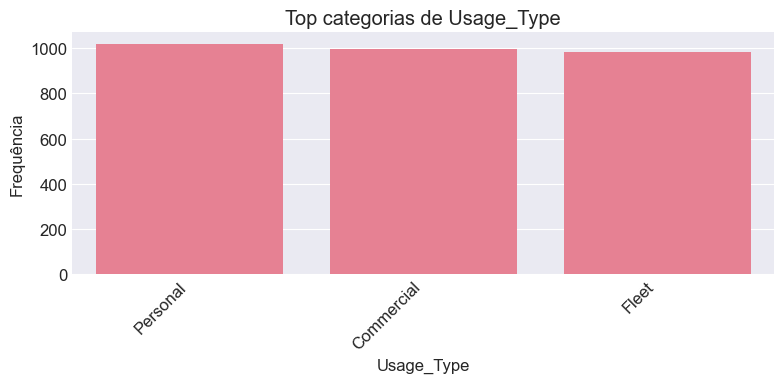

In [10]:
# 5. ANÁLISE DE VARIÁVEIS CATEGÓRICAS
# ------------------------------------
print("\n" + "=" * 60)
print("5. ANÁLISE DE VARIÁVEIS CATEGÓRICAS")
print("=" * 60)

categorical_cols = df.select_dtypes(include=["object", "category"]).columns.tolist()
print(f"Variáveis categóricas ({len(categorical_cols)}):")
print(categorical_cols)

for col in categorical_cols:
    counts = df[col].value_counts().head(15)
    plt.figure(figsize=(8, 4))
    sns.barplot(x=counts.index, y=counts.values)
    plt.xticks(rotation=45, ha="right")
    plt.title(f"Top categorias de {col}")
    plt.ylabel("Frequência")
    plt.xlabel(col)
    plt.tight_layout()
    plt.show()


6. COMPARAÇÃO DE GRUPOS (ANOVA)

--- Make x Resale_Value_USD ---


,count,mean,median,std
Make,,,,
BMW,311,22868.385852,22893.0,5299.098893
Mercedes,293,22621.853242,22532.0,5499.735774
Ford,323,22596.486068,22532.0,5734.615227
Audi,289,22469.273356,22532.0,5802.871067
Hyundai,297,22342.676768,22272.0,5556.061066
Chevrolet,308,22230.779221,21762.5,5646.041567
Kia,286,22091.870629,21630.0,5620.048621
Nissan,298,21874.651007,21808.0,5622.010167
Tesla,287,21840.675958,22238.0,5502.713180


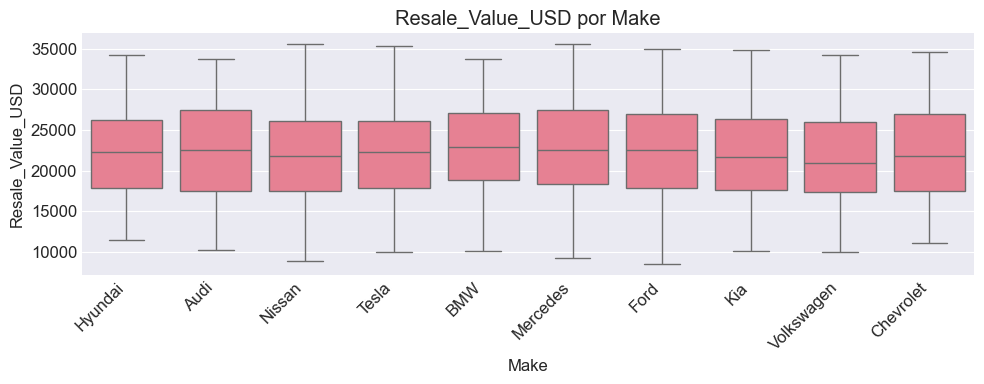

,sum_sq,df,F,PR(>F)
C(Make),4.449778e+08,9.0,1.582184,0.114629
Residual,9.343510e+10,2990.0,NaN,NaN



--- Region x Resale_Value_USD ---


,count,mean,median,std
Region,,,,
North America,740,22586.341892,22537.5,5702.068605
Europe,719,22529.246175,22667.0,5504.798363
Asia,747,22077.799197,22157.0,5641.179991
Australia,794,21872.263224,21444.0,5510.526295


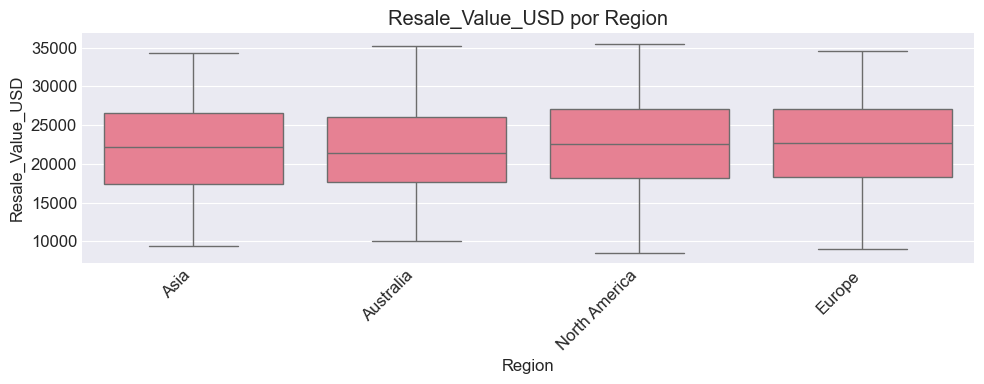

,sum_sq,df,F,PR(>F)
C(Region),2.750739e+08,3.0,2.934748,0.032176
Residual,9.360501e+10,2996.0,NaN,NaN



--- Vehicle_Type x Resale_Value_USD ---


,count,mean,median,std
Vehicle_Type,,,,
Sedan,738,22356.470190,22508.5,5647.441226
SUV,765,22324.611765,22325.0,5567.659726
Truck,724,22229.714088,22126.5,5610.863173
Hatchback,773,22120.825356,21832.0,5564.551529


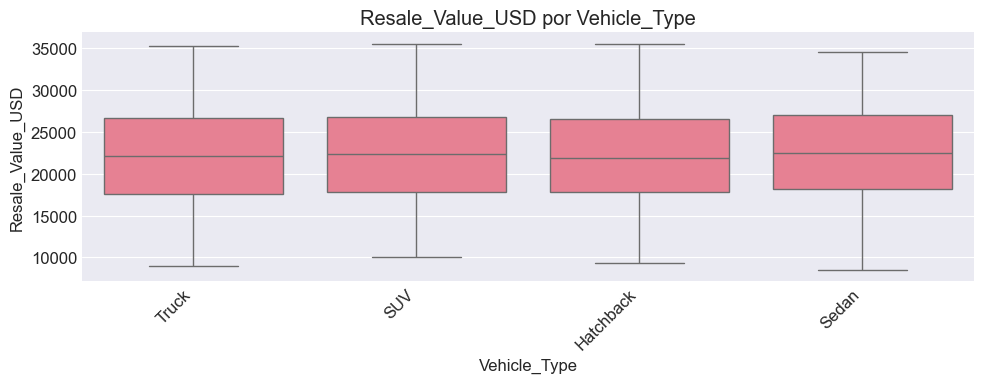

,sum_sq,df,F,PR(>F)
C(Vehicle_Type),2.567227e+07,3.0,0.273168,0.84479
Residual,9.385441e+10,2996.0,NaN,NaN



--- Usage_Type x Resale_Value_USD ---


,count,mean,median,std
Usage_Type,,,,
Personal,1020,22382.998039,22407.5,5582.873265
Fleet,984,22276.772358,22290.5,5646.931366
Commercial,996,22108.546185,21849.0,5557.839807


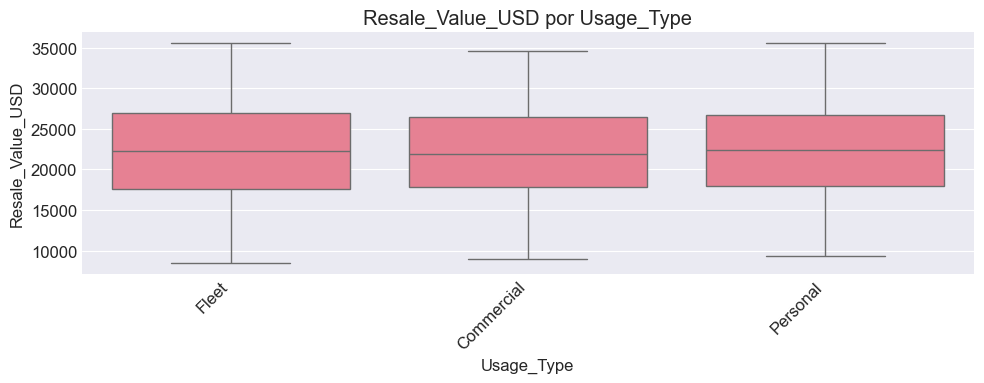

,sum_sq,df,F,PR(>F)
C(Usage_Type),3.852808e+07,2.0,0.615232,0.540584
Residual,9.384155e+10,2997.0,NaN,NaN


In [11]:
# 6. COMPARAÇÃO DE GRUPOS + ANOVA
# --------------------------------
print("\n" + "=" * 60)
print("6. COMPARAÇÃO DE GRUPOS (ANOVA)")
print("=" * 60)

df_model = df.dropna(subset=[target_col]).copy()
group_cols = ["Make", "Region", "Vehicle_Type", "Usage_Type"]


def group_summary_and_anova(df: pd.DataFrame, group_col: str, target: str) -> None:
    """
    Calcula estatísticas agregadas do target por grupo e aplica ANOVA de uma via.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame com os dados.
    group_col : str
        Coluna categórica para formar grupos.
    target : str
        Nome da variável-alvo numérica.
    """
    print(f"\n--- {group_col} x {target} ---")
    agg = (
        df.groupby(group_col)[target]
        .agg(["count", "mean", "median", "std"])
        .sort_values("mean", ascending=False)
    )
    display(agg.head(15))

    plt.figure(figsize=(10, 4))
    sns.boxplot(data=df, x=group_col, y=target)
    plt.xticks(rotation=45, ha="right")
    plt.title(f"{target} por {group_col}")
    plt.tight_layout()
    plt.show()

    formula = f"{target} ~ C({group_col})"
    model = ols(formula, data=df).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    display(anova_table)


for col in group_cols:
    if col in df_model.columns:
        group_summary_and_anova(df_model, col, target_col)
    else:
        print(f"[AVISO] Coluna {col} não encontrada no DataFrame.")


7. CORRELAÇÕES COM A VARIÁVEL-ALVO


,pearson_corr
Resale_Value_USD,1.000
Battery_Capacity_kWh,0.916
Range_km,0.861
Charging_Time_hr,0.249
Year,0.245
Insurance_Cost_USD,0.024
Maintenance_Cost_USD,0.016
Energy_Consumption_kWh_per_100km,0.011
Charging_Power_kW,0.000
Electricity_Cost_USD_per_kWh,-0.001


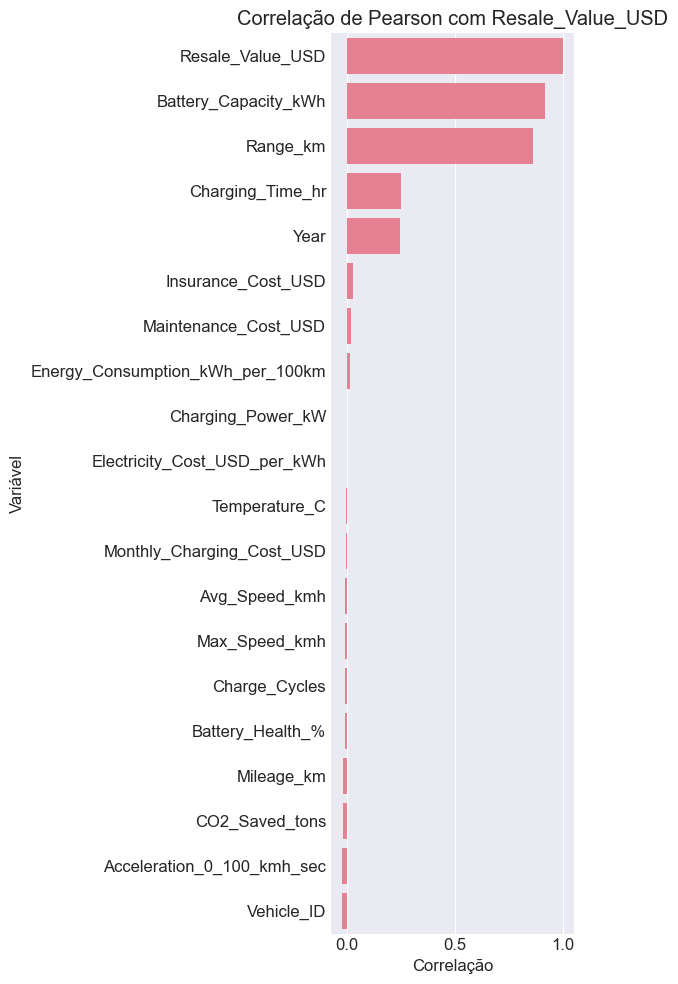

📁 Correlações salvas em: ..\data\outputs\reports\correlacoes_Resale_Value_USD_2025-12-02_13-42-13.csv


In [12]:
# 7. CORRELAÇÕES COM A VARIÁVEL-ALVO
# -----------------------------------
print("\n" + "=" * 60)
print("7. CORRELAÇÕES COM A VARIÁVEL-ALVO")
print("=" * 60)

numeric_cols_model = df_model.select_dtypes(include=[np.number]).columns.tolist()
if target_col in numeric_cols_model:
    corr = df_model[numeric_cols_model].corr()[target_col].sort_values(ascending=False)
    display(corr.to_frame("pearson_corr").round(3))

    plt.figure(figsize=(6, 10))
    sns.barplot(x=corr.values, y=corr.index)
    plt.title(f"Correlação de Pearson com {target_col}")
    plt.xlabel("Correlação")
    plt.ylabel("Variável")
    plt.tight_layout()
    plt.show()

    corr.to_csv(REPORTS_PATH / f"correlacoes_{target_col}_{timestamp}.csv")
    print(f"📁 Correlações salvas em: {REPORTS_PATH / f'correlacoes_{target_col}_{timestamp}.csv'}")
else:
    print(f"[AVISO] {target_col} não é numérico. Correlação não calculada.")